In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

AttributeError: module 'scipy' has no attribute '_lib'

In [ ]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')

In [ ]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [ ]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025

fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [ ]:

zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

In [34]:
ds

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 27)
Coordinates:
    niter    int64 ...
  * time     (time) int64 0 0 3600 7200 10800 ... 75600 79200 82800 86400 90000
    x0       (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0       float64 ...
Dimensions without coordinates: i, j
Data variables:
    u        (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    v        (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>

In [6]:
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

eta_merged = eta_merged.isel(time=slice(1,110))

eta_merged = eta_merged.drop_vars('time')

In [7]:
def lanczos(x, a):
    return np.sinc(x/a)

In [8]:
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [9]:
nofiles=49
eta_eul_filtered = eta_merged.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
eta_eul_filtered = eta_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_unfiltered = eta_merged.Eta.chunk({'time':-1}).sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [10]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,49):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where((ds.u!=-999).all(dim='time'))
        mask_roundx = abs(ds.x.diff('time')).max('time')
        mask_roundy = abs(ds.y.diff('time')).max('time')
        ds = ds.where(mask_roundx<30)
        ds = ds.where(mask_roundy<30)
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_eta = ds.eta.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        eta_piece = windowed_eta.sel(time=0).isel(z0=3)
        eta_piece2 = ds.eta.sel(time=0).isel(z0=3)
        eta_piece["time"] = fileno*3600
        eta_piece2["time"] = fileno*3600
        if fileno==0:
            eta_filtered = eta_piece
            eta_unfiltered = eta_piece2
        else:
            eta_filtered = xr.concat([eta_filtered,eta_piece],dim='time')
            eta_unfiltered = xr.concat([eta_unfiltered,eta_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

In [11]:
def lin_func(s, a=1, b=1, c=1):
    x,y=s
    return a * x+ b * y + c

In [15]:
fit_eta_unf = eta_unfiltered.chunk({'y0':-1,'x0':-1}).curvefit(["x0","y0"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface_unf = lin_func((eta_unfiltered.x0,eta_unfiltered.y0),fit_eta_unf.curvefit_coefficients.sel(param='a'), 
                       fit_eta_unf.curvefit_coefficients.sel(param='b'), fit_eta_unf.curvefit_coefficients.sel(param='c'))
eta_unfiltered_detr = (eta_unfiltered-fit_surface_unf) 

fit_eta = eta_filtered.chunk({'y0':-1,'x0':-1}).curvefit(["x0","y0"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((eta_filtered.x0,eta_filtered.y0),fit_eta.curvefit_coefficients.sel(param='a'), 
                       fit_eta.curvefit_coefficients.sel(param='b'), fit_eta.curvefit_coefficients.sel(param='c'))
eta_filtered_detr = (eta_filtered-fit_surface) 

fit_eta = eta_eul_filtered.chunk({'i':-1,'j':-1}).curvefit(["i","j"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((eta_eul_filtered.i,eta_eul_filtered.j),fit_eta.curvefit_coefficients.sel(param='a'), 
                       fit_eta.curvefit_coefficients.sel(param='b'), fit_eta.curvefit_coefficients.sel(param='c'))
eta_eul_filtered_detr = (eta_eul_filtered-fit_surface)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


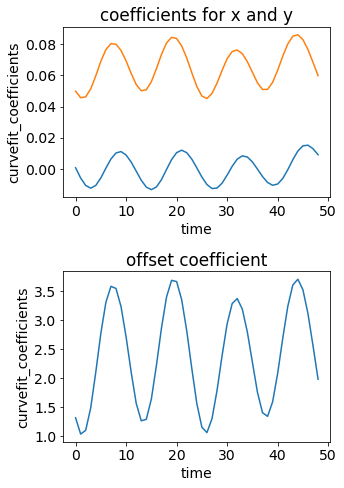

In [32]:
plt.figure(figsize=(5,7))
plt.subplot(211)
fit_eta_unf.curvefit_coefficients.sel(param='a').assign_coords(time=fit_eta_unf.time/3600).plot()
fit_eta_unf.curvefit_coefficients.sel(param='b').assign_coords(time=fit_eta_unf.time/3600).plot()
plt.title('coefficients for x and y')

plt.subplot(212)
fit_eta_unf.curvefit_coefficients.sel(param='c').assign_coords(time=fit_eta_unf.time/3600).plot()
plt.title('offset coefficient')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('curvefit_coeffs.png')


In [26]:
with ProgressBar():
    etahat_un = xrft.power_spectrum(eta_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'
    etahat_un_detr = xrft.power_spectrum(eta_unfiltered_detr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()
    

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[                                        ] | 2% Completed |  7.4s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  3min 10.9s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[                                        ] | 0% Completed |  9.9s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  3min 56.6s


In [28]:
with ProgressBar():
    etahat2 = xrft.power_spectrum(eta_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                               ).compute()#, detrend='linear'
    etahat2_detr = xrft.power_spectrum(eta_filtered_detr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                               ).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[##                                      ] | 6% Completed |  1min 44.3s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 35min 37.3s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[                                        ] | 0% Completed | 30.7s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 46min  5.0s


In [29]:
#spectrum_filtered_eul
with ProgressBar():
    etahat2eul = xrft.power_spectrum(eta_eul_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                    ).compute()
    etahat2eul_detr = xrft.power_spectrum(eta_eul_filtered_detr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                         ).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 18.0s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  1min 41.1s


In [30]:
spec0 = int((etahat2['freq_time'].size-1)/2)

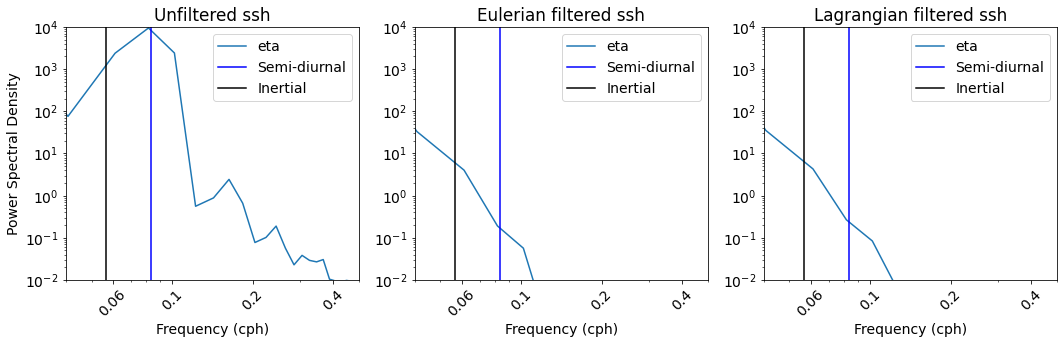

In [31]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(etahat_un.freq_time[spec0:]*3600,etahat_un.mean(['x0','y0'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.ylabel('Power Spectral Density')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(etahat2eul.freq_time[spec0:]*3600,etahat2eul.mean(['i','j'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(133)
plt.plot(etahat2.freq_time[spec0:]*3600,etahat2.mean(['x0','y0'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('eta_filt_unfilt.png')

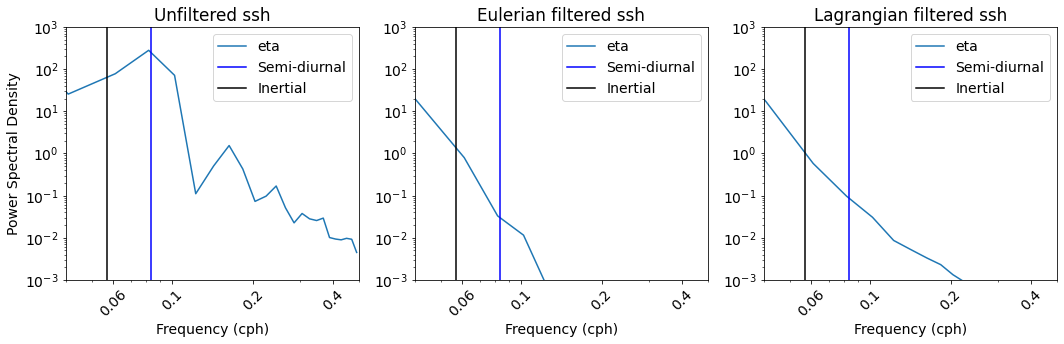

In [39]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(etahat_un.freq_time[spec0:]*3600,etahat_un_detr.mean(['x0','y0'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.ylabel('Power Spectral Density')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered ssh')
plt.ylim(10**-3,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(etahat2eul.freq_time[spec0:]*3600,etahat2eul_detr.mean(['i','j'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered ssh')
plt.ylim(10**-3,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(133)
plt.plot(etahat2.freq_time[spec0:]*3600,etahat2_detr.mean(['x0','y0'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered ssh')
plt.ylim(10**-3,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('eta_filt_unfilt.png')

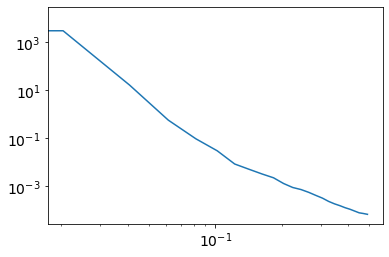

In [37]:
plt.plot(etahat2.freq_time[spec0:]*3600,etahat2_detr.mean(['x0','y0'])[spec0:],label='eta')
plt.xscale('log')
plt.yscale('log')

In [16]:
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", etahat2.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", etahat2.y0.values)).swap_dims({"j": "y0"})

In [17]:
lons, lats = np.meshgrid(eta_filtered.x0.values, eta_filtered.y0.values)

In [18]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [19]:
eta_eul_resampled = ufunc_resample(eta_eul_filtered.load())
eta_resampled = ufunc_resample(eta_filtered.load())
eta_resampled_unfilt = ufunc_resample(eta_unfiltered.load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to

In [22]:
eta_eul_resampled = eta_eul_resampled.assign_coords(x1=("x1", eta_eul_resampled.x1.values)).assign_coords(y1=("y1", eta_eul_resampled.y1.values))
eta_resampled = eta_resampled.assign_coords(x1=("x1", eta_resampled.x1.values)).assign_coords(y1=("y1", eta_resampled.y1.values))
eta_resampled_unfilt = eta_resampled_unfilt.assign_coords(x1=("x1", eta_resampled_unfilt.x1.values)).assign_coords(y1=("y1", eta_resampled_unfilt.y1.values))


In [23]:
def lin_func(s, a=1, b=1, c=1):
    x,y=s
    return a * x+ b * y + c

In [33]:
fit_eta = eta_resampled_unfilt.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((eta_resampled_unfilt.x1,eta_resampled_unfilt.y1),fit_eta.curvefit_coefficients.sel(param='a'), 
                       fit_eta.curvefit_coefficients.sel(param='b'), fit_eta.curvefit_coefficients.sel(param='c'))
eta_resampled_unfilt_detr = (eta_resampled_unfilt-fit_surface)

fit_eta = eta_resampled.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((eta_resampled.x1,eta_resampled.y1),fit_eta.curvefit_coefficients.sel(param='a'), 
                       fit_eta.curvefit_coefficients.sel(param='b'), fit_eta.curvefit_coefficients.sel(param='c'))
eta_resampled_detr = (eta_resampled-fit_surface)

fit_eta = eta_eul_resampled.curvefit(["x1","y1"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface = lin_func((eta_eul_resampled.x1,eta_eul_resampled.y1),fit_eta.curvefit_coefficients.sel(param='a'), 
                       fit_eta.curvefit_coefficients.sel(param='b'), fit_eta.curvefit_coefficients.sel(param='c'))
eta_eul_resampled_detr = (eta_eul_resampled-fit_surface)

In [34]:
with ProgressBar():
    eta2_ps = xrft.power_spectrum(eta_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta2_ps_detr = xrft.power_spectrum(eta_resampled_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [26]:
with ProgressBar():
    eta2_ps_unfilt = xrft.power_spectrum(eta_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta2_ps_unfilt_detr = xrft.power_spectrum(eta_resampled_unfilt_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [35]:
with ProgressBar():
    eta2_ps_eul = xrft.power_spectrum(eta_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta2_ps_eul_detr = xrft.power_spectrum(eta_eul_resampled_detr, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [36]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [37]:
ps_iso = iso_spec(eta2_ps)
ps_iso_unfilt = iso_spec(eta2_ps_unfilt)
ps_iso_eul = iso_spec(eta2_ps_eul)
ps_iso_unfilt_detr = iso_spec(eta2_ps_unfilt_detr)
ps_iso_detr = iso_spec(eta2_ps_detr)
ps_iso_eul_detr = iso_spec(eta2_ps_eul_detr)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [38]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 6])
for i in range(1,6):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


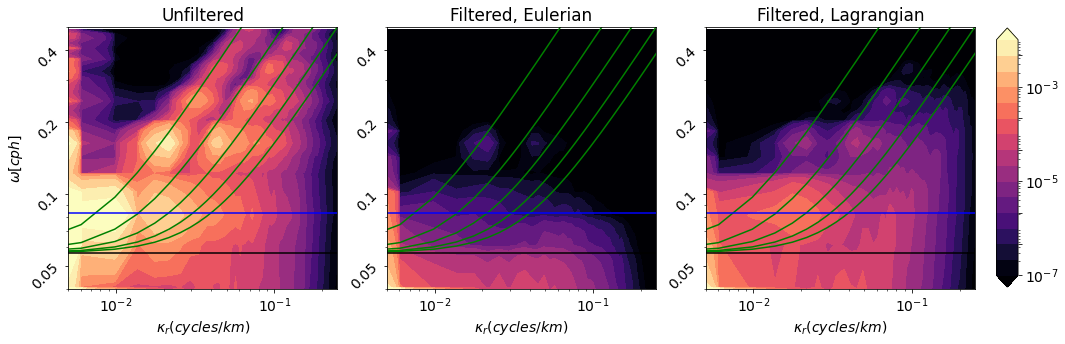

In [39]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-7,-2,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq_eta.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


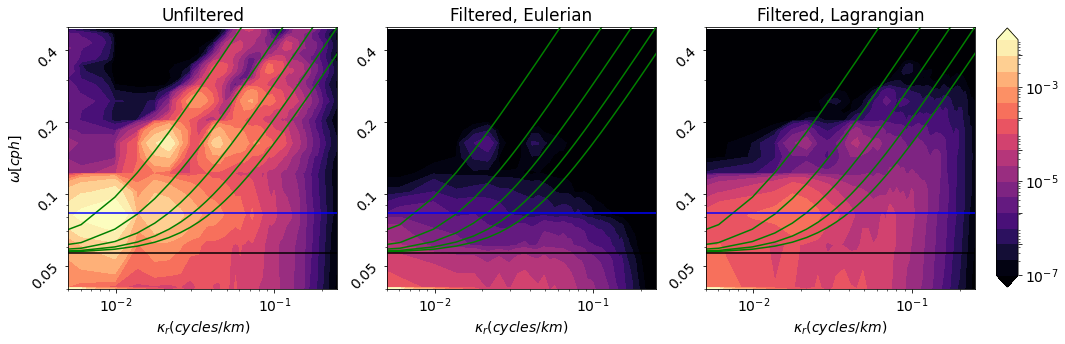

In [40]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-7,-2,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt_detr,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul_detr,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_detr,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq_eta_detr.png')

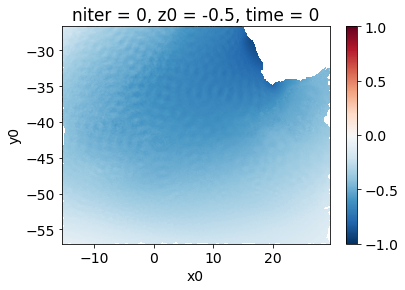

In [41]:
(eta_unfiltered-eta_filtered).sel(time=0).plot(x='x0',vmax=1,vmin=-1,cmap='RdBu_r')

In [42]:
(eta_eul_unfiltered-eta_eul_filtered).isel(time=0).plot(x='i',vmax=1,vmin=-1,cmap='RdBu_r')

MemoryError: Unable to allocate 79.2 TiB for an array with shape (2160, 2160, 2160, 2160) and data type float32

In [44]:
import iris
from eofs.xarray import Eof

In [45]:
solver = Eof(eta_resampled_detr)

In [46]:
eofs = solver.eofs(neofs=10)
pcs = solver.pcs(npcs=10, pcscaling=1)
evs = solver.eigenvalues(neigs=10)

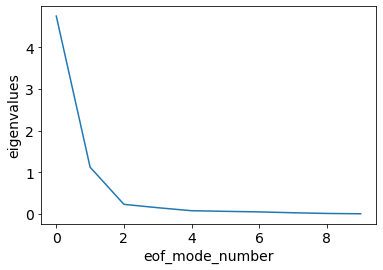

In [47]:
evs.plot()

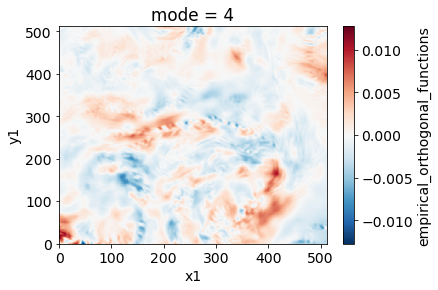

In [58]:
eofs.isel(mode=4).plot(x='x1')

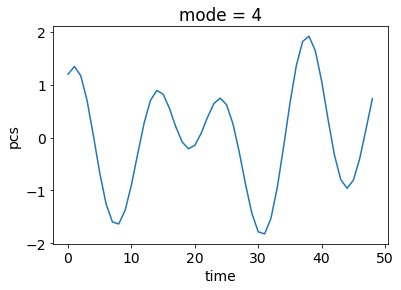

In [57]:
pcs.isel(mode=4).assign_coords(time=pcs.time/3600).plot()

In [104]:
eta_filtered#.isel(time=0).plot()

<xarray.DataArray (time: 49, x0: 2160, y0: 2160)>
array([[[        nan, -1.35138634, -1.34971968, ...,         nan,
                 nan,         nan],
        [-0.9583481 ,         nan, -1.34285562, ...,         nan,
                 nan, -0.39912991],
        [-1.02234582, -1.3228716 , -1.36505712, ...,  0.11996076,
          0.12012065, -0.37940131],
        ...,
        [        nan, -1.06041032, -1.05339557, ...,         nan,
                 nan,         nan],
        [        nan, -1.05727495, -1.05041525, ...,         nan,
                 nan,         nan],
        [        nan, -1.05661268, -1.049755  , ...,         nan,
                 nan,         nan]],

       [[        nan, -1.32562526, -1.32366021, ...,         nan,
                 nan,         nan],
        [-0.96192633,         nan, -1.32140971, ...,         nan,
                 nan, -0.37011231],
        [-1.0133767 , -1.29500223, -1.35684276, ...,  0.12471135,
                 nan, -0.3435416 ],
...
        [        nan,         nan, -1.20312766, ...,         nan,
                 nan,         nan],
        [        nan, -1.19955845, -1.21154535, ...,         nan,
                 nan,         nan],
        [        nan, -1.22663489, -1.22254804, ...,         nan,
                 nan,         nan]],

       [[-1.07651585, -1.24026141, -1.2385556 , ...,         nan,
                 nan,         nan],
        [-1.18528957, -1.34567724, -1.34642784, ...,         nan,
                 nan,         nan],
        [-1.16010656, -1.39242481, -1.39251246, ...,  0.13923533,
          0.10761025,  0.02468394],
        ...,
        [        nan,         nan, -1.17979157, ...,         nan,
                 nan,         nan],
        [        nan, -1.18637616, -1.18178608, ...,         nan,
                 nan,         nan],
        [        nan, -1.18957596, -1.18580021, ...,         nan,
                 nan,         nan]]])
Coordinates:
    niter    int64 0
  * x0       (x0) float64 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
  * y0       (y0) float64 -57.0 -56.99 -56.98 -56.97 ... -26.69 -26.68 -26.66
    z0       float64 -0.5
  * time     (time) int64 0 3600 7200 10800 ... 162000 165600 169200 172800